# Code to analyse SII, S 65 dB at BCD-side, in silence

22 July 2023 Guido Cattani

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
from scipy.stats import wilcoxon as wilcoxon
from scipy.stats import rankdata as rankdata
from scipy.stats import shapiro as shapiro

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def read_SII():
    f_in =  '/media/guido/LACIE/Cingle_Guido/Master/Implant/Calculated_data/SII_Sbcd65_silence.csv'
    p_in = Path(f_in)   
    df = pd.read_csv(p_in, index_col = 'Study_ID')
    df = df.fillna(pd.NA)
    return df

In [5]:
def descriptive_stat(df):
    # calculate quantiles
    quantiles = df.quantile([0.1, 0.5, 0.9]).round(3)
    quantiles.index = ['P10', 'P50', 'P90']
 
    # calculate mean and standard deviation
    mean_values = (pd.DataFrame({'Mean': df.mean().round(3)})).T
    std_values = (pd.DataFrame({'St. dev.': df.std().round(3)})).T

    # perform Shapiro test 
    sht = shapiro_test_norm(df)

    # combine results into a single DataFrame
    res = pd.concat([quantiles, mean_values, std_values, sht])
    
    return res.round(3)

In [6]:
def shapiro_test_norm(df):
    # check normality with Shapiro-Wilk test
    shapiro_result = df.apply(lambda x: shapiro(x) if len(x) >= 3 else (float('nan'), float('nan')))
    
    shapiro_stats = shapiro_result.apply(lambda x: round(x[0], 3))
    p_values = shapiro_result.apply(lambda x: round(x[1], 3))
    is_normal = p_values >= 0.05
    
    shapiro_test = pd.DataFrame({
        'Shapiro test statistic': shapiro_stats,
        'p-value': p_values,
        'normally distributed': is_normal
    }).transpose()
    
    return shapiro_test

In [7]:
sii = read_SII()
sii

,AC_path,BC_path,AC&BC_path,diff_combi_AC
Study_ID,,,,
34,0.930,0.869,0.981,0.051
35,0.901,0.885,0.982,0.081
43,0.968,0.916,0.987,0.019
47,0.968,0.899,0.997,0.029
50,0.968,0.896,0.987,0.019
53,0.960,0.888,0.966,0.006
54,0.926,0.903,1.000,0.074
56,0.870,0.885,0.997,0.127
59,0.968,0.883,0.992,0.024


In [8]:
des_stat = descriptive_stat(sii)
des_stat

,AC_path,BC_path,AC&BC_path,diff_combi_AC
P10,0.924,0.87,0.977,0.013
P50,0.966,0.886,0.988,0.027
P90,0.968,0.909,0.998,0.075
Mean,0.952,0.889,0.988,0.036
St. dev.,0.027,0.016,0.01,0.029
Shapiro test statistic,0.682,0.966,0.929,0.786
p-value,0.0,0.664,0.145,0.001
normally distributed,False,True,True,False


In [9]:
# name file quantiles results
f_ar = "SII_SbcdNnone.csv"

In [10]:
# save quantiles to file
d_ar = "/media/guido/LACIE/Cingle_Guido/Master/Implant/Analysis_Results/"
p_ar = Path(d_ar + f_ar)
des_stat.to_csv(p_ar)

In [11]:
score = sii.T.to_numpy()

In [12]:
# Wilcoxon signed-rank
w = wilcoxon(score[3])
w

WilcoxonResult(statistic=0.0, pvalue=1.9073486328125e-06)

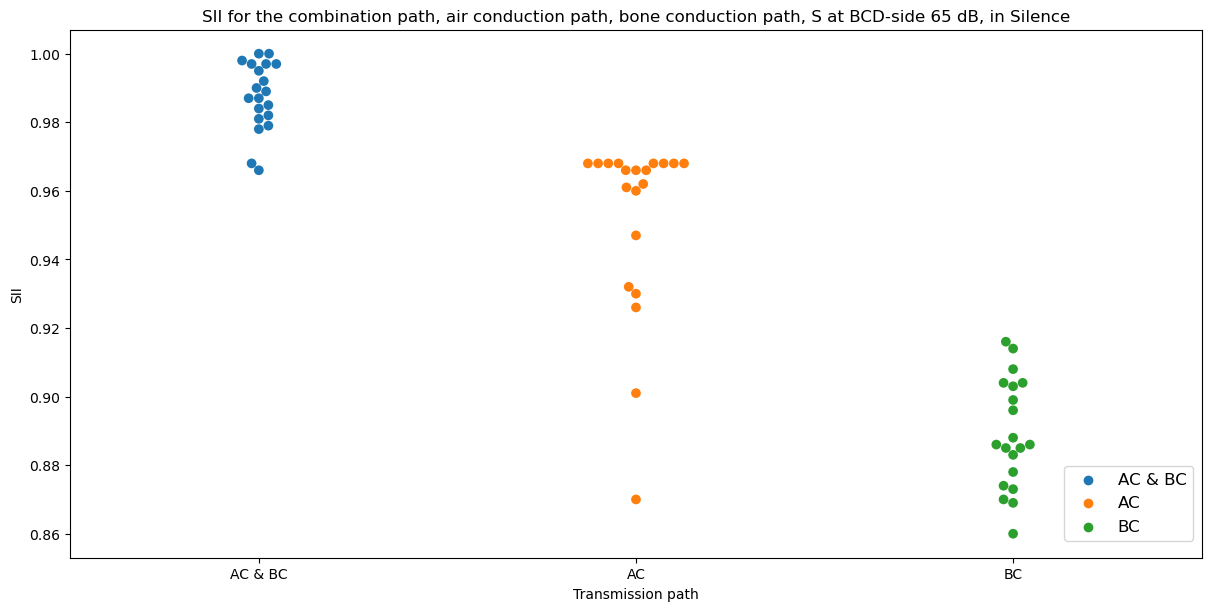

In [13]:
# make a figure to plot SII for the 3 paths
ttl = 'SII for the combination path, air conduction path, bone conduction path, S at BCD-side 65 dB, in Silence'
sii_combi = sii['AC&BC_path']
sii_ac = sii['AC_path']
sii_bc = sii['BC_path']
tp = pd.melt(pd.DataFrame( {'AC & BC' : sii_combi, 'AC' : sii_ac, 'BC' : sii_bc }), 
             var_name = 'Transmission path', value_name = 'SII') 

fig, ax = plt.subplots(constrained_layout=True)

sns.color_palette("colorblind")

fig.set_figheight(6)
fig.set_figwidth(12)

ax = sns.swarmplot(data = tp, x = 'Transmission path', y = 'SII', hue = 'Transmission path', size=7)

ax.set_title(ttl)
ax.set_yticks(np.arange(np.min(score[:-1]), np.max(score[:-1]), 0.02))
plt.legend(bbox_to_anchor=(1, 0.19), fontsize='large')

# save the figure
plt.savefig('/media/guido/LACIE/Cingle_Guido/Master/Implant/Analysis_Graphs/SII_SbcdNnone.tiff', 
            transparent=False, dpi=500, bbox_inches="tight")

plt.show()